In [46]:
import pandas as pd
import matplotlib.pyplot as plot

*Fetching the data and basic analysis*

In [47]:
df_housing = pd.read_csv('housing.csv')

*Quick description of data*

In [48]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


*The data consists of 20k instances and 10 features*

In [49]:
df_housing.shape

(20640, 10)

In [50]:
df_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


*Plot histograms of numerical features to get idea about the distibutions of the data*

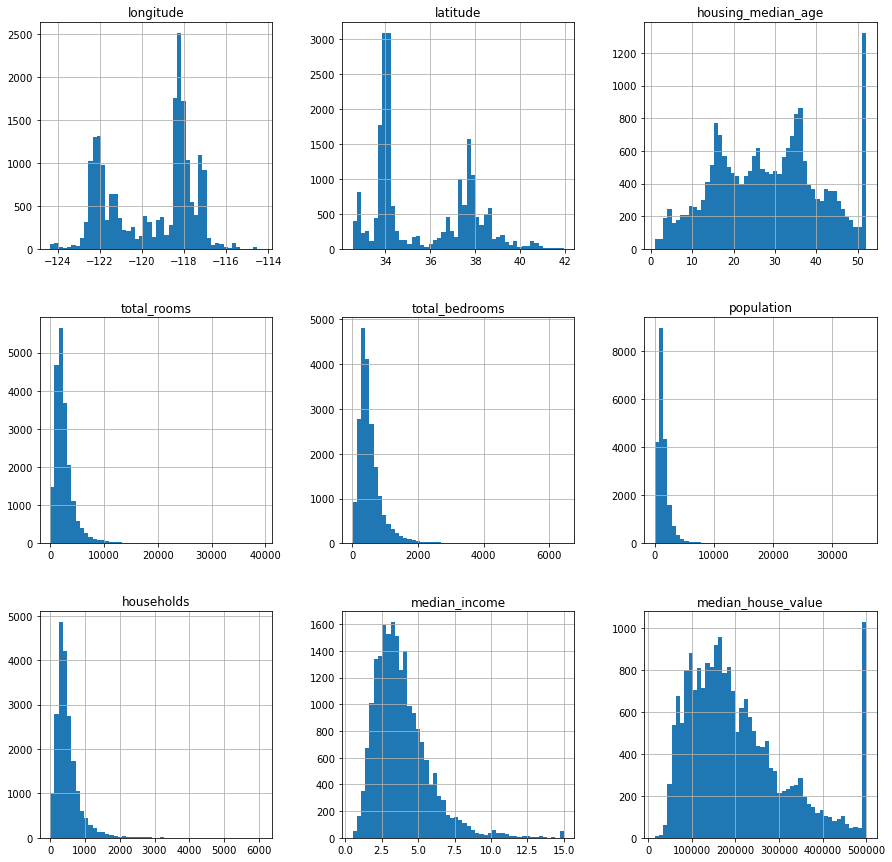

In [51]:
df_housing.hist(bins=50, figsize=(15,15))
plot.show()

*Looking at the histograms above -*
1. Distribution is not normal (i.e skewed to left)
2. median income and age appear not scaled

------------------

*To properly represent the population in our sample we are going to use stratified splitting*

In [52]:
import numpy as np

df_housing['income_category'] = pd.cut(df_housing['median_income'],
                                      bins = [0.,1.5,3.,4.5,6.,np.inf],
                                      labels = [1,2,3,4,5])

Text(0.5, 1.0, 'Income categories')

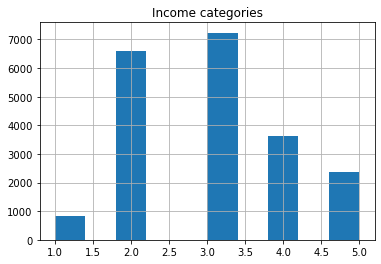

In [53]:
df_housing['income_category'].hist()
plot.title('Income categories')


----

### Creating a train test set

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

split_obj = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 50)

for train_index, test_index in split_obj.split(df_housing, df_housing['income_category']):
    strat_train_set = df_housing.loc[train_index]
    strat_test_set =  df_housing.loc[test_index]

*PS - Removing the income category column to match the original dataset*

In [55]:
for index in (strat_train_set, strat_test_set):
    index.drop('income_category', axis = 1, inplace = True)

### Discover and visualize the data

In [56]:
df_housing = strat_train_set.copy()

*Visualizing geographical data*

Text(0.5, 1.0, 'Housing Prices based on Locations')

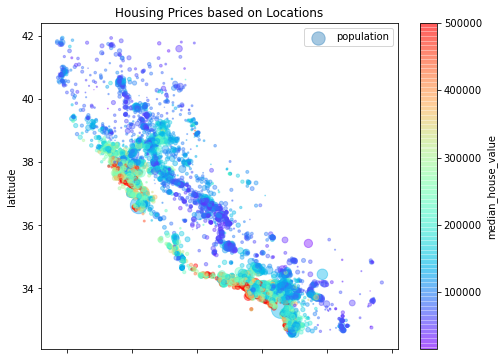

In [58]:
df_housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
               s = df_housing['population'] / 100, label = 'population', figsize = (8,6),
               c = 'median_house_value', cmap = plot.get_cmap('rainbow'), colorbar = True)
plot.legend()
plot.title('Housing Prices based on Locations')


----

*Checking correlations and creating new features*

In [59]:
df_housing['rooms_per_household'] = df_housing['total_rooms'] / df_housing['households']
df_housing['bedrooms_per_household'] = df_housing['total_bedrooms'] / df_housing['households']
df_housing['population_per_household'] = df_housing['population'] / df_housing['households']

In [60]:
df_housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686930
rooms_per_household         0.151308
total_rooms                 0.137060
housing_median_age          0.103783
households                  0.066502
total_bedrooms              0.052708
population                 -0.024807
population_per_household   -0.027231
bedrooms_per_household     -0.039081
longitude                  -0.048513
latitude                   -0.140663
Name: median_house_value, dtype: float64

*Looking at the above values, you can say **rooms_per_household** is important feature*

------


In [61]:
df_housing = strat_train_set.drop('median_house_value', axis = 1)
df_housing_labels = strat_train_set['median_house_value'].copy()

### Preparing data for ML model

*Dropping the categorical value to process numerical and categorical values separately*

In [62]:
df_housing_num = df_housing.drop('ocean_proximity', axis = 1)

In [63]:
df_housing_cat = df_housing[['ocean_proximity']]

*For Numerical attributes*

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


num_pipepline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scalar', StandardScaler())
])

df_housing_num_tr = num_pipepline.fit_transform(df_housing_num)

*For Categorical attribute*

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attr = list(df_housing_num)
cat_attr = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipepline, num_attr),
    ('cat', OneHotEncoder(), cat_attr)
])

df_housing_prep = full_pipeline.fit_transform(df_housing)

### Selecting and Training a model

In [66]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_housing_prep, df_housing_labels)

LinearRegression()

*Testing a small model*

In [68]:
some_data = df_housing.iloc[:5]
some_labels = df_housing_labels.iloc[:5]

some_data_prep = full_pipeline.transform(some_data)

print('Prepdictions', lin_reg.predict(some_data_prep))
print('\n')
print('Labels', list(some_labels))



Prepdictions [333433.75909024 294934.80253637 252226.58079111 224501.50029941
 254901.3663774 ]


Labels [383200.0, 319100.0, 250900.0, 171100.0, 229300.0]


### Evaluating the model

*Using RMSE*

In [70]:
from sklearn.metrics import mean_squared_error

df_housing_pred = lin_reg.predict(df_housing_prep)

rmse = np.sqrt(mean_squared_error(df_housing_labels,df_housing_pred))

print('Root means square error', rmse)

Root means square error 68777.12503644277


*Using Cross-validation and RMSE*

In [72]:
from sklearn.model_selection import cross_val_score

lin_reg_scores = np.sqrt(-cross_val_score(lin_reg, df_housing_prep, df_housing_labels,
                        scoring = 'neg_mean_squared_error', cv = 10))

In [77]:
print(f'Scores: {lin_reg_scores} \n Mean: {lin_reg_scores.mean()} \n Standard dev: {lin_reg_scores.std()}')

Scores: [68452.46638595 69504.73871183 73594.89926873 70335.14115848
 66760.17626857 67036.99810208 67198.37396596 67145.4544666
 70670.82157768 68480.03301364] 
 Mean: 68917.9102919516 
 Standard dev: 2049.39651945066


#### Choosing a different model (Random Forest)

In [78]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(df_housing_prep, df_housing_labels)

RandomForestRegressor()

In [79]:
rmse = np.sqrt(mean_squared_error(df_housing_labels, forest_reg.predict(df_housing_prep)))

print('Root means square error', rmse)

Root means square error 18094.951753305697


In [82]:
forest_reg_scores = np.sqrt(-cross_val_score(forest_reg, df_housing_prep, df_housing_labels,
                        scoring = 'neg_mean_squared_error', cv = 10))

print(f'Scores: {forest_reg_scores} \n Mean: {forest_reg_scores.mean()} \n Standard dev: {forest_reg_scores.std()}')

Scores: [46101.6896818  50304.92308911 49127.06379331 50308.209547
 46733.93139042 49236.26641159 46995.80579718 49138.36876174
 51390.96733541 47620.23294235] 
 Mean: 48695.74587499082 
 Standard dev: 1665.8988468532907


### Fine tune your model

*Grid Search*

In [83]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[10,20,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)

grid_search.fit(df_housing_prep, df_housing_labels)

grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

### Evaluate Test set

In [85]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

x_test_prep = full_pipeline.transform(x_test)

final_pred = final_model.predict(x_test_prep)

final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))

print(f'Root mean square on test set {final_rmse}')

Root mean square on test set 49683.88458373171
